In [1]:
import numpy as np
import stim

import tree_code_helper
from rgs_config import Node, Pauli, RgsConfig
from rgs_probability_calculation import prob_rgs_trial

### Checkpoints

- apply loss to every photons?
- track every side effects 
    - every time there's a measurement occurs
    - photons (excluding last level) from push-out of emitters
    - photons (first-level only) from the joining outer with inner qubits
    - anchor emitter from joining outer with inner qubits
    - recap
        - inner photons (non first/non last): from generations
        - inner photons first-level: from outer/inner join
        - inner photons first-level: from two halves joining
        - outer photons: from joining inner/outer (also track the H)
        - anchor: outer/inner join

In [2]:
def helper_apply_photon_loss(conf: RgsConfig, photon: int) -> bool:
    """returns a bool indicating whether the qubit is lost or not"""
    conf.total_photons += 1
    if conf.rng.random() >= conf.loss_probability:
        return False
    conf.lost_photons += 1
    conf.t.x_error(photon, p=0.5)
    conf.t.z_error(photon, p=0.5)
    conf.t.measure(photon)
    return True


def helper_update_eigenvalue_with_side_effect(conf: RgsConfig):

    def __update_eigenvalue_with_side_effect_recurse(root: Node):
        if (not root.is_lost) and (root.measurement_basis == Pauli.X) and (root.has_z):
            assert root.eigenvalue is not None
            root.eigenvalue = not root.eigenvalue
        for v in root.children:
            __update_eigenvalue_with_side_effect_recurse(v)

    for meas_tree in conf.measurement_trees:
        for root in meas_tree:
            __update_eigenvalue_with_side_effect_recurse(root)


def helper_decode_logical_result(conf: RgsConfig) -> bool:
    """decode logical qubit from all measurements (all info stored in config)
    and returns a boolean indicating whether all inner qubits can be decoded or not"""
    for i, meas_tree in enumerate(conf.measurement_trees):
        x_decode_count = 0
        z_decode_count = 0
        for arm, root in enumerate(meas_tree):
            if conf.succeeded_bsm_arm_indices[i // 2] == arm:
                x_decode_count += 1
                conf.logical_results[i][arm] = tree_code_helper.decode_tree_logical_x(root)
            else:
                z_decode_count += 1
                conf.logical_results[i][arm] = tree_code_helper.decode_tree_logical_z(root)
        assert x_decode_count == 1
        assert z_decode_count == conf.m - 1
    return all([m is not None for arms in conf.logical_results for m in arms])

### General Idea of how to optimize the simulation

1. We keep the required qubits in the system at a time to the minimum, i.e., minimum emitters and photons.
    1. we simulate hop-by-hop fashion, creating two half-RGSs, and the action at the ABSA between them.
    2. Beyond the first hop, the Bell pairs created thus far are stored in two memories between two nodes (thus 2 memories here)
    3. The next hop, creating by another set of emitters and at most 2 photons at a time (2 anchors; 2 outer emitters; 2 photons; one set of inner qubit emitters |bv|)

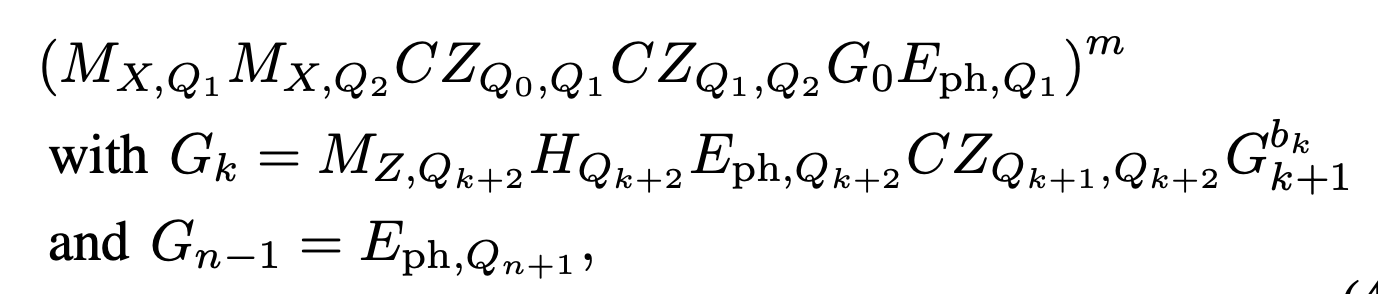

looks like the equation is wrong for G_k? It should be that G_k states are anchored at G_{k+2} so the index needs to be added by 1 for the CZ and MZ

In [3]:
def generate_and_measure_inner_qubit(conf: RgsConfig, logical_basis: Pauli, root: Node):
    """Generate and measure an inner logical qubit, which comprises of lots of physical qubits."""

    # specifying the basis (i.e., X or Z) will be measured in the odd level while even will be the other basis (i.e., Z or X)
    # this is opposite of what we wrote in the paper since we count the level of the tree from 0 (in the paper we count from 1)
    even_basis = logical_basis
    if even_basis == Pauli.X:
        odd_basis = Pauli.Z
    else:
        odd_basis = Pauli.X
    n = len(conf.bv)

    # postorder lists
    postorder_measurement_bases: list[Pauli | None] = []
    postorder_measurement_results: list[bool | None] = []
    postorder_photon_lost: list[bool] = []
    postorder_side_effects: list[bool] = []

    # short hand
    t = conf.t
    photon = conf.photon
    emitters = conf.emitters

    def __recurse_generate_and_measure(i):
        # one call generates one child (subtree) of emitter i-th
        # from having (j, b_{i+1}, b{i+2}, ..., b_{n-1}) to (j + 1, b_{i+1}, b{i+2}, ..., b_{n-1})
        # initially, j is 0 for the first call
        # we assume that the emitters are always in the |+> state,
        # so we need to reinitialize it every time we perform measurements on an emitter.
        basis = odd_basis if i % 2 == 1 else even_basis
        if i == n - 1:
            # generation part: G_{n-1}
            t.reset(photon)
            t.cx(emitters[i], photon)
            t.h(photon)  # to fix up the H side effect

            conf.circuit.append("R", photon)
            conf.circuit.append("CX", [emitters[i], photon])
            conf.circuit.append("H", photon)

            # measurement part
            if helper_apply_photon_loss(conf, photon):
                postorder_photon_lost.append(True)
                postorder_measurement_bases.append(None)
                postorder_measurement_results.append(None)
                postorder_side_effects.append(False)
            else:
                if basis == Pauli.X:
                    t.h(photon)
                    conf.circuit.append("H", photon)
                postorder_photon_lost.append(False)
                postorder_measurement_bases.append(basis)
                postorder_measurement_results.append(t.measure(photon))
                postorder_side_effects.append(False)
                conf.circuit.append("M", photon)
        else:
            # generation part: G_k
            for _ in range(conf.bv[i + 1]):
                # G_{i+1} ^ (b_{i+1}); this is anchored at emitter[i+1]
                __recurse_generate_and_measure(i + 1)
            t.cz(emitters[i], emitters[i + 1])
            t.reset(photon)
            t.cx(emitters[i + 1], photon)
            t.h(emitters[i + 1])
            postorder_side_effects.append(t.measure(emitters[i + 1]))
            t.reset_x(emitters[i + 1])  # reinitialize emitter q_{i+1}

            conf.circuit.append("CZ", [emitters[i], emitters[i+1]])
            conf.circuit.append("R", photon)
            conf.circuit.append("CX", [emitters[i+1], photon])
            conf.circuit.append("H", emitters[i+1])
            conf.circuit.append("M", emitters[i+1])
            conf.circuit.append("RX", emitters[i+1])

            # measure the newly created photon at level k
            if helper_apply_photon_loss(conf, photon):
                postorder_photon_lost.append(True)
                postorder_measurement_bases.append(None)
                postorder_measurement_results.append(None)
            else:
                if basis == Pauli.X:
                    t.h(photon)
                postorder_photon_lost.append(False)
                postorder_measurement_bases.append(basis)
                postorder_measurement_results.append(t.measure(photon))

    for _ in range(conf.bv[0]):
        __recurse_generate_and_measure(0)

    postorder_nodes = root.get_postorder_traversal()

    assert len(postorder_nodes) - 1 == len(postorder_measurement_results)
    assert len(postorder_measurement_bases) == len(postorder_measurement_results)
    assert len(postorder_side_effects) == len(postorder_measurement_results)
    assert len(postorder_photon_lost) == len(postorder_measurement_results)

    # we don't need the last entry since it is the outer photon
    for i, u in enumerate(postorder_nodes[:-1]):
        u.has_z = u.has_z ^ postorder_side_effects[i]
        u.measurement_result = u.eigenvalue = postorder_measurement_results[i]
        u.measurement_basis = postorder_measurement_bases
        u.is_lost = postorder_photon_lost[i]

In [4]:
def rgs_protocol_helper_one_hop(conf: RgsConfig, left_anchor: int, right_anchor: int, hop_index: int) -> bool:
    """This function process one hop of the loss-only RGS trial with the two qubit anchors are provided via `left_anchor` and `right_anchor`.
    Returns whether the BSM of outer qubits are successful or not, so the simulation can stop early"""

    """In here, we streamline the previous version by generating one photon at a time (two for BSM). Most of the complexity of the optimized version lies here.
    This function does the following.
    --------------------------------
    """
    t = conf.t
    left_outer_emitter = conf.outer_emitter_left
    right_outer_emitter = conf.outer_emitter_right
    left_photon = conf.photon_left
    right_photon = conf.photon_right
    emitters = conf.emitters

    # debugging
    x_measurement_count = 0
    z_measurement_count = 0

    # print(left_anchor, right_anchor)
    # print(t.canonical_stabilizers())
    assert t.peek_x(left_anchor) == 1
    assert t.peek_x(right_anchor) == 1

    for arm in range(conf.m):
        # generate outer qubits for both sides
        assert t.peek_x(left_outer_emitter) == 1
        assert t.peek_x(right_outer_emitter) == 1
        for i in emitters:
            assert t.peek_x(i) == 1

        t.reset(left_photon, right_photon)
        t.cx(left_outer_emitter, left_photon)
        t.cx(right_outer_emitter, right_photon)
        t.h(left_photon, right_photon)  # we perform H to fix up into the graph states

        conf.circuit.append("R", [left_photon, right_photon])
        conf.circuit.append("CX", [left_outer_emitter, left_photon, right_outer_emitter, right_photon])
        conf.circuit.append("H", [left_photon, right_photon])

        # BSM part
        left_is_lost = helper_apply_photon_loss(conf, left_photon)
        right_is_lost = helper_apply_photon_loss(conf, right_photon)

        # reference to measurement record
        left_root = conf.measurement_trees[2 * hop_index][arm]
        right_root = conf.measurement_trees[2 * hop_index + 1][arm]

        # 3 cases that can happen for BSM:
        #   (1) one or both photon lost
        #   (2) BSM succeeded (50% linear optics) -- results are different (+1/-1 or -1/+1)
        #   (3) BSM failed -- results are the same (+1+1 or -1-1)
        if left_is_lost or right_is_lost:
            bsm_is_successful = False
        else:
            # BSM when both photons arrive
            t.cz(left_photon, right_photon)
            t.h(left_photon, right_photon)
            left_result, right_result = t.measure(left_photon), t.measure(right_photon)
            bsm_is_successful = (left_result != right_result)

            conf.circuit.append("CZ", [left_photon, right_photon])
            conf.circuit.append("MX", [left_photon, right_photon])

        if bsm_is_successful:
            left_root.is_lost = right_root.is_lost = False
            left_root.measurement_basis = right_root.measurement_basis = Pauli.X
            left_root.eigenvalue = left_root.measurement_result = left_result
            right_root.eigenvalue = right_root.measurement_result = right_result
        else:
            # we store the result for fail BSM as if they are lost
            left_root.is_lost = right_root.is_lost = True
            left_root.measurement_basis = right_root.measurement_basis = None
            left_root.eigenvalue = left_root.measurement_result = None
            right_root.eigenvalue = right_root.measurement_result = None

        # choose pair to keep if we haven't got one yet
        if conf.succeeded_bsm_arm_indices[hop_index] == -1 and bsm_is_successful:
            conf.succeeded_bsm_arm_indices[hop_index] = arm
            inner_qubit_measurement_basis = Pauli.X
        else:
            inner_qubit_measurement_basis = Pauli.Z

        # debugging
        if inner_qubit_measurement_basis == Pauli.X:
            x_measurement_count += 1
        else:
            z_measurement_count += 1

        # inner qubit: left
        generate_and_measure_inner_qubit(conf, inner_qubit_measurement_basis, left_root)
        t.cz(left_anchor, left_outer_emitter)
        t.cz(left_outer_emitter, emitters[0])
        t.h(left_outer_emitter, emitters[0])
        outer_emitter_meas, inner_emitter_meas = t.measure(left_outer_emitter), t.measure(emitters[0])
        t.reset_x(left_outer_emitter, emitters[0])

        conf.circuit.append("CZ", [left_anchor, left_outer_emitter, left_outer_emitter, emitters[0]])
        conf.circuit.append("MX", [left_outer_emitter, emitters[0]])
        conf.circuit.append("RX", [left_outer_emitter, emitters[0]])

        for q in [left_outer_emitter, *emitters]:
            assert t.peek_x(q) == 1

        if inner_emitter_meas:
            t.z(left_anchor)
            left_root.has_z = not left_root.has_z
        if outer_emitter_meas:
            for u in left_root.children:
                u.has_z = not u.has_z

        # inner qubit: right
        generate_and_measure_inner_qubit(conf, inner_qubit_measurement_basis, right_root)
        t.cz(right_anchor, right_outer_emitter)
        t.cz(right_outer_emitter, emitters[0])
        t.h(right_outer_emitter, emitters[0])
        outer_emitter_meas, inner_emitter_meas = t.measure(right_outer_emitter), t.measure(emitters[0])
        t.reset_x(right_outer_emitter, emitters[0])

        conf.circuit.append("CZ", [right_anchor, right_outer_emitter, right_outer_emitter, emitters[0]])
        conf.circuit.append("MX", [right_outer_emitter, emitters[0]])
        conf.circuit.append("RX", [right_outer_emitter, emitters[0]])

        for q in [right_outer_emitter, *emitters]:
            assert t.peek_x(q) == 1

        if inner_emitter_meas:
            t.z(right_anchor)
            right_root.has_z = not right_root.has_z
        if outer_emitter_meas:
            for u in right_root.children:
                u.has_z = not u.has_z

    # debugging
    if conf.succeeded_bsm_arm_indices[hop_index] == -1:
        assert x_measurement_count == 0 and z_measurement_count == conf.m
    else:
        assert x_measurement_count == 1 and z_measurement_count == conf.m - 1

    return conf.succeeded_bsm_arm_indices[hop_index] != -1

In [13]:
def rgs_protocol_trial_loss_only(conf: RgsConfig) -> bool:
    """This function accepts all the parameters specifying a single Bell pair distribution trial via the RGS protocol, only accounting for photon loss.
    It returns a boolean specifying whether the run is successful or not.
    This can be used to verify the success probability of the protocol against the theoretical model."""

    conf.reset()
    # short hand variables
    t = conf.t
    alice = conf.alice
    bob = conf.bob
    # left_anchor = conf.anchor_left
    # right_anchor = conf.anchor_right
    measurement_trees = conf.measurement_trees

    # first hop, we perform a single-hop RGS from half-RGSs between memories (0 and 1)
    # all photons between the two halfs are generated and measured
    trial_is_running = rgs_protocol_helper_one_hop(conf, conf.alice, conf.bob, 0)
    if not trial_is_running:
        return False

    # subsequent hops along the path
    for hop_index in range(1, conf.number_of_hops):
        # join the two Bell pairs, equivalent to the action of joining two half-RGSs at RGSS (i-1) th (not counting the two end nodes; Alice and Bob)
        trial_is_running = rgs_protocol_helper_one_hop(conf, conf.anchor_left, conf.anchor_right, hop_index)
        if not trial_is_running:
            return False
        #           2 * hop - 1 | 2 * hop        2 * hop + 1
        # from: left --- (right | temp_left) --- temp_right
        # swap: left --------------------------- temp_right
        # want: left --- (right | temp_left)     temp_right
        t.cz(conf.bob, conf.anchor_left)
        t.h(conf.bob, conf.anchor_left)
        left_meas, right_meas = t.measure(conf.bob), t.measure(conf.anchor_left)
        t.reset_x(conf.bob, conf.anchor_left)
        t.swap(conf.bob, conf.anchor_right)

        if left_meas:
            for arm in measurement_trees[2 * hop_index]:
                for u in arm.children:
                    u.has_z = not u.has_z
        if right_meas:
            for arm in measurement_trees[2 * hop_index - 1]:
                for u in arm.children:
                    u.has_z = not u.has_z

    # (Protocol Step 1) Update measurements tree by assigning eigenvalues to the nodes taking side effects into account
    helper_update_eigenvalue_with_side_effect(conf)

    # (Protocol Step 2) Propagating side effects of BSMs of outer qubits into their connected inner qubits
    for hop_index in range(conf.number_of_hops):
        # view at absa
        left_tree_root = measurement_trees[2 * hop_index][conf.succeeded_bsm_arm_indices[hop_index]]
        right_tree_root = measurement_trees[2 * hop_index + 1][conf.succeeded_bsm_arm_indices[hop_index]]
        # debugging
        assert not left_tree_root.is_lost
        assert not right_tree_root.is_lost
        assert type(left_tree_root.eigenvalue) is bool
        assert type(right_tree_root.eigenvalue) is bool
        if left_tree_root.eigenvalue:
            for u in right_tree_root.children:
                if u.is_lost:
                    continue
                assert u.eigenvalue is not None
                u.eigenvalue = not u.eigenvalue
        if right_tree_root.eigenvalue:
            for u in left_tree_root.children:
                if u.is_lost:
                    continue
                assert u.eigenvalue is not None
                u.eigenvalue = not u.eigenvalue

    # (Protocol Step 2/3?) Decoding logical measurements
    if not helper_decode_logical_result(conf):
        return False

    # (Protocol Step 3) Compute parity at each ABSA for Pauli frame corrections
    left_parities = []  # to be sent to Alice (left end node)
    right_parities = []  # to be sent to Bob (right end node)
    for hop_index in range(conf.number_of_hops):
        # view at ABSA
        left_logicals = conf.logical_results[2 * hop_index]
        right_logicals = conf.logical_results[2 * hop_index + 1]

        # assert all(left_logicals) and all(right_logicals)

        lp, rp = False, False
        for i in range(conf.m):
            if i == conf.succeeded_bsm_arm_indices[hop_index]:
                continue
            lp ^= left_logicals[i]
            rp ^= right_logicals[i]
        lp ^= right_logicals[conf.succeeded_bsm_arm_indices[hop_index]]
        rp ^= left_logicals[conf.succeeded_bsm_arm_indices[hop_index]]

        left_parities.append(lp)
        right_parities.append(rp)

    # (Protocol Step 4) Combining all the parities from all ABSAs and correct at end nodes
    combined_left_parity, combined_right_parity = False, False
    for i in range(conf.number_of_hops):
        combined_left_parity ^= left_parities[i]
        combined_right_parity ^= right_parities[i]
    
    if combined_left_parity:
        t.z(alice)
    if combined_right_parity:
        t.z(bob)

    
    # print(f'hereeeee')
    # print(t.canonical_stabilizers())
    # t.swap(1, 3)
    # display(conf.circuit.diagram('timeline-svg'))

    
    # print(t.canonical_stabilizers()[:2])x
    if t.peek_observable_expectation(stim.PauliString("XZ")) == 1 and t.peek_observable_expectation(stim.PauliString("ZX")) == 1:
        conf.correct_bell_pair_count += 1
    elif t.peek_observable_expectation(stim.PauliString("XZ")) == 0 or t.peek_observable_expectation(stim.PauliString("ZX")) == 0:
        conf.unentangled_pair_count += 1
    else:
        assert t.peek_observable_expectation(stim.PauliString("XZ")) == 1 or t.peek_observable_expectation(stim.PauliString("XZ")) == -1  
        assert t.peek_observable_expectation(stim.PauliString("ZX")) == 1 or t.peek_observable_expectation(stim.PauliString("ZX")) == -1
        # print(t.canonical_stabilizers()[:2])
        conf.incorrect_bell_pair_count += 1

    return True

In [14]:
conf = RgsConfig(1, 1, [1], 0, stim.TableauSimulator())

def rgs_trial_experiment_run(required_runs: int, number_of_hops: int, m: int, bv: int, photon_loss_probability: float, show_progress_mark=False):
    global conf
    num_ticks = 10
    progress_marks = [int(i * required_runs / num_ticks) for i in range(1, num_ticks)]
    progress_marks.append(required_runs)

    tab_sim = stim.TableauSimulator()
    conf = RgsConfig(number_of_hops, m, bv, photon_loss_probability, tab_sim)
    actual_run_count = 0

    print(f"start RGS protocol trials for {number_of_hops} hops with photon loss probability between RGSS and ABSA {photon_loss_probability}.")
    print(f"      RGS parameters are given by m = {m} and branching parameters {bv}.")
    print(f"============================")

    while actual_run_count < required_runs:
        # while (good_count + bad_count) < required_runs:
        conf.t = stim.TableauSimulator()
        conf.reset()
        rgs_protocol_trial_loss_only(conf)
        actual_run_count += 1
        # progress print
        if show_progress_mark and actual_run_count in progress_marks:
            print(f"    has been running for {actual_run_count} trials with {conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count} successful distribution(s).")

    print(f"photon accounting loss_rate = {conf.lost_photons/conf.total_photons} ({conf.lost_photons}/{conf.total_photons})")
    print(f"good count ({conf.correct_bell_pair_count}), incorrect decoding ({conf.incorrect_bell_pair_count}), product state ({conf.unentangled_pair_count})")
    if conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count > 0:
        print(f"incorrect decoding ratio = {conf.incorrect_bell_pair_count/(conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count)}")
        print(f"product state ratio = {conf.unentangled_pair_count/(conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count)}")
    print("----------------------")
    print(f"theoretical success probability is {prob_rgs_trial(m, bv, (1-photon_loss_probability), number_of_hops)}")
    print(
        f"success probability = {(conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count) / actual_run_count} ({conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count}/{actual_run_count})"
    )
    print("----------------------")
    print(f"ran {actual_run_count} times")

In [17]:
# # 1-hop cases; no loss
rgs_trial_experiment_run(100, 1, 2, [1], 0, True)

start RGS protocol trials for 1 hops with photon loss probability between RGSS and ABSA 0.
      RGS parameters are given by m = 2 and branching parameters [1].
    has been running for 10 trials with 7 successful distribution(s).
    has been running for 20 trials with 12 successful distribution(s).
    has been running for 30 trials with 19 successful distribution(s).
    has been running for 40 trials with 25 successful distribution(s).
    has been running for 50 trials with 35 successful distribution(s).
    has been running for 60 trials with 42 successful distribution(s).
    has been running for 70 trials with 52 successful distribution(s).
    has been running for 80 trials with 61 successful distribution(s).
    has been running for 90 trials with 68 successful distribution(s).
    has been running for 100 trials with 76 successful distribution(s).
photon accounting loss_rate = 0.0 (0/800)
good count (23), incorrect decoding (53), product state (0)
incorrect decoding ratio = 

In [10]:
t=stim.TableauSimulator()
t.do(conf.circuit)
t.canonical_stabilizers()

[stim.PauliString("-X__Z___"),
 stim.PauliString("-Z__X___"),
 stim.PauliString("+_X_____"),
 stim.PauliString("+__X____"),
 stim.PauliString("+____X__"),
 stim.PauliString("-_____X_"),
 stim.PauliString("+______Z")]

In [10]:
# with more than one arm and with lossy links
# at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km
rgs_trial_experiment_run(200, 10, 14, [10, 5], 0.1, True)

start RGS protocol trials for 10 hops with photon loss probability between RGSS and ABSA 0.1.
      RGS parameters are given by m = 14 and branching parameters [10, 5].
    has been running for 20 trials with 19 successful distribution(s).
    has been running for 40 trials with 38 successful distribution(s).
    has been running for 60 trials with 58 successful distribution(s).
    has been running for 80 trials with 76 successful distribution(s).
    has been running for 100 trials with 95 successful distribution(s).
    has been running for 120 trials with 115 successful distribution(s).
    has been running for 140 trials with 135 successful distribution(s).
    has been running for 160 trials with 155 successful distribution(s).
    has been running for 180 trials with 175 successful distribution(s).
    has been running for 200 trials with 194 successful distribution(s).
photon accounting loss_rate = 0.10008952330891291 (341222/3409168)
good count (54), incorrect decoding (140), 

start RGS protocol trials for 1 hops with photon loss probability between RGSS and ABSA 0.
      RGS parameters are given by m = 2 and branching parameters [1].


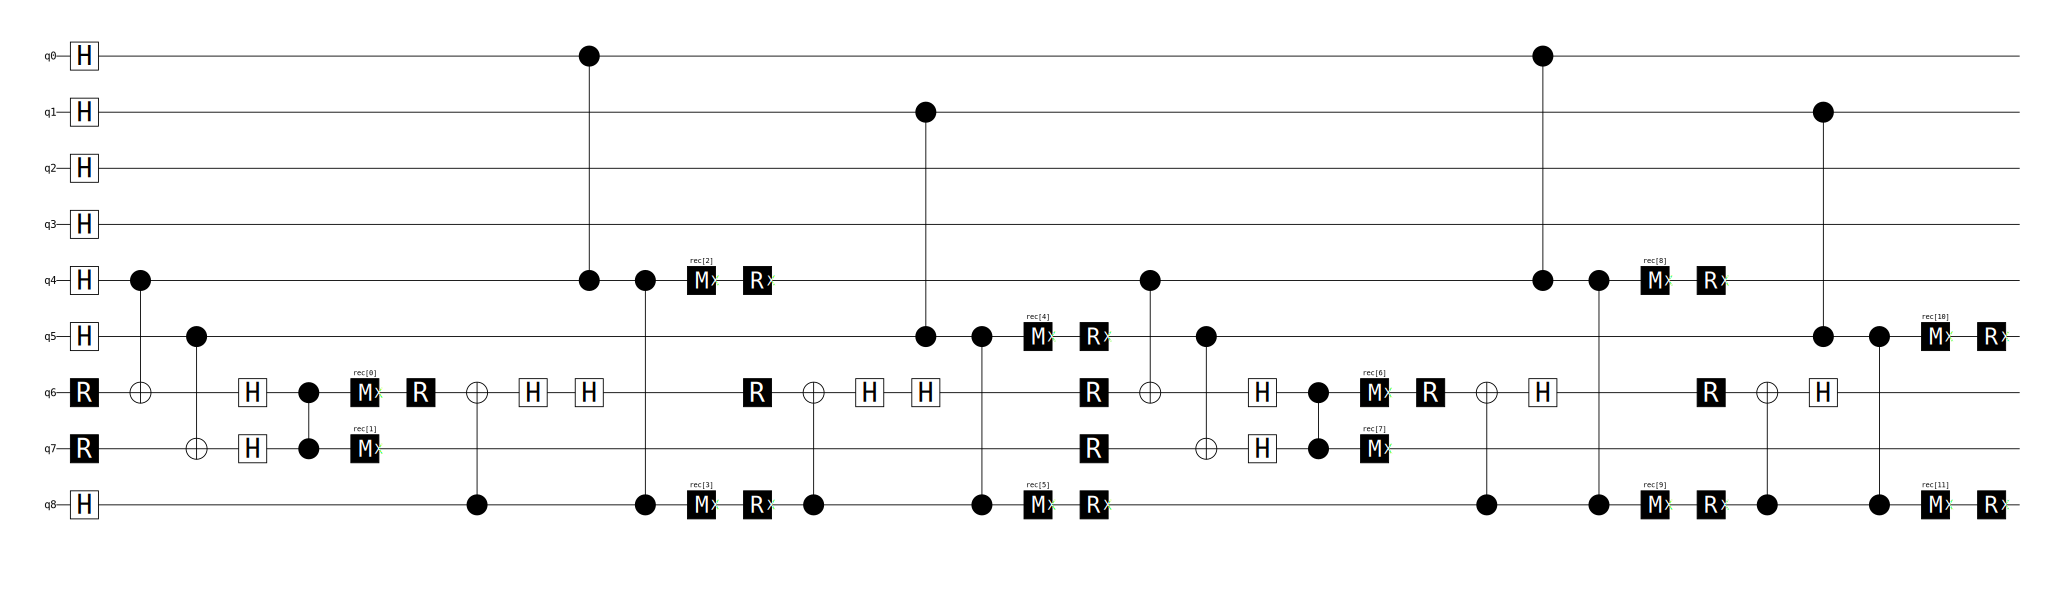

    has been running for 1 trials with 1 successful distribution(s).
photon accounting loss_rate = 0.0 (0/8)
good count (0), incorrect decoding (1), product state (0)
incorrect decoding ratio = 1.0
product state ratio = 0.0
----------------------
theoretical success probability is 0.75
success probability = 1.0 (1/1)
----------------------
ran 1 times


In [7]:
# # 1-hop cases; no loss
rgs_trial_experiment_run(1, 1, 2, [1], 0, True)

In [8]:
# # with more than one arm and with lossy links
# # at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km
# rgs_trial_experiment_run(100, 1, 14, [10, 5], 0.1, True)

In [9]:
# # with more than one arm and with lossy links
# # at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km
# rgs_trial_experiment_run(1000, 2, 14, [10, 5], 0.1, True)

In [10]:
# # 1-hop cases; no loss
# rgs_trial_experiment_run(1000, 1, 1, [1], 0, True)

In [11]:
# # 1-hop cases; with loss
# rgs_trial_experiment_run(1000, 1, 1, [1], 0.1, True)

In [12]:
# # 3-hop cases; with loss 
# rgs_trial_experiment_run(1000, 3, 1, [1], 0.1, True)

In [13]:
# # 1-hop cases; no loss multiple arms
# rgs_trial_experiment_run(1000, 1, 3, [1], 0, True)

In [14]:
# # 1-hop cases; with loss multiple arms
# rgs_trial_experiment_run(1000, 1, 3, [1], 0.1, True)

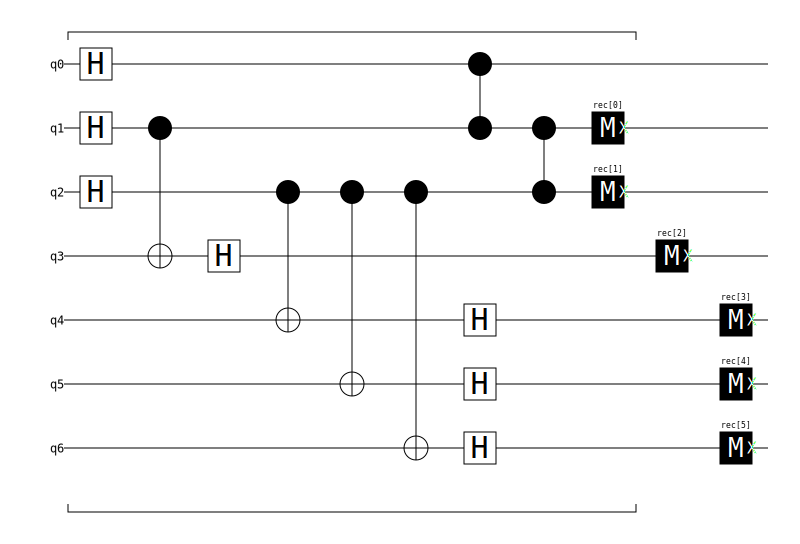

In [7]:
import stim
c = stim.Circuit("""
H 0 1 2
CX 1 3
H 3
CX 2 4 2 5 2 6
H 4 5 6
CZ 0 1 1 2
MX 1 2
TICK
MX 3
TICK
MX 4 5 6
""")

c.diagram('timeline-svg')

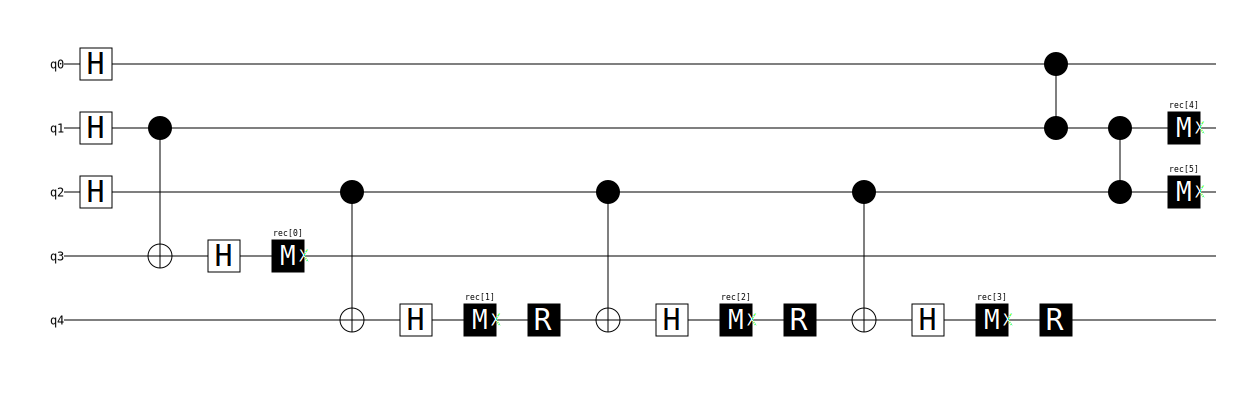

In [11]:
import stim
c = stim.Circuit("""
H 0 1 2
CX 1 3
H 3
MX 3
CX 2 4
H 4
MX 4
R 4
CX 2 4
H 4
MX 4
R 4
CX 2 4
H 4
MX 4
R 4
CZ 0 1 1 2
MX 1 2
""")

c.diagram('timeline-svg')

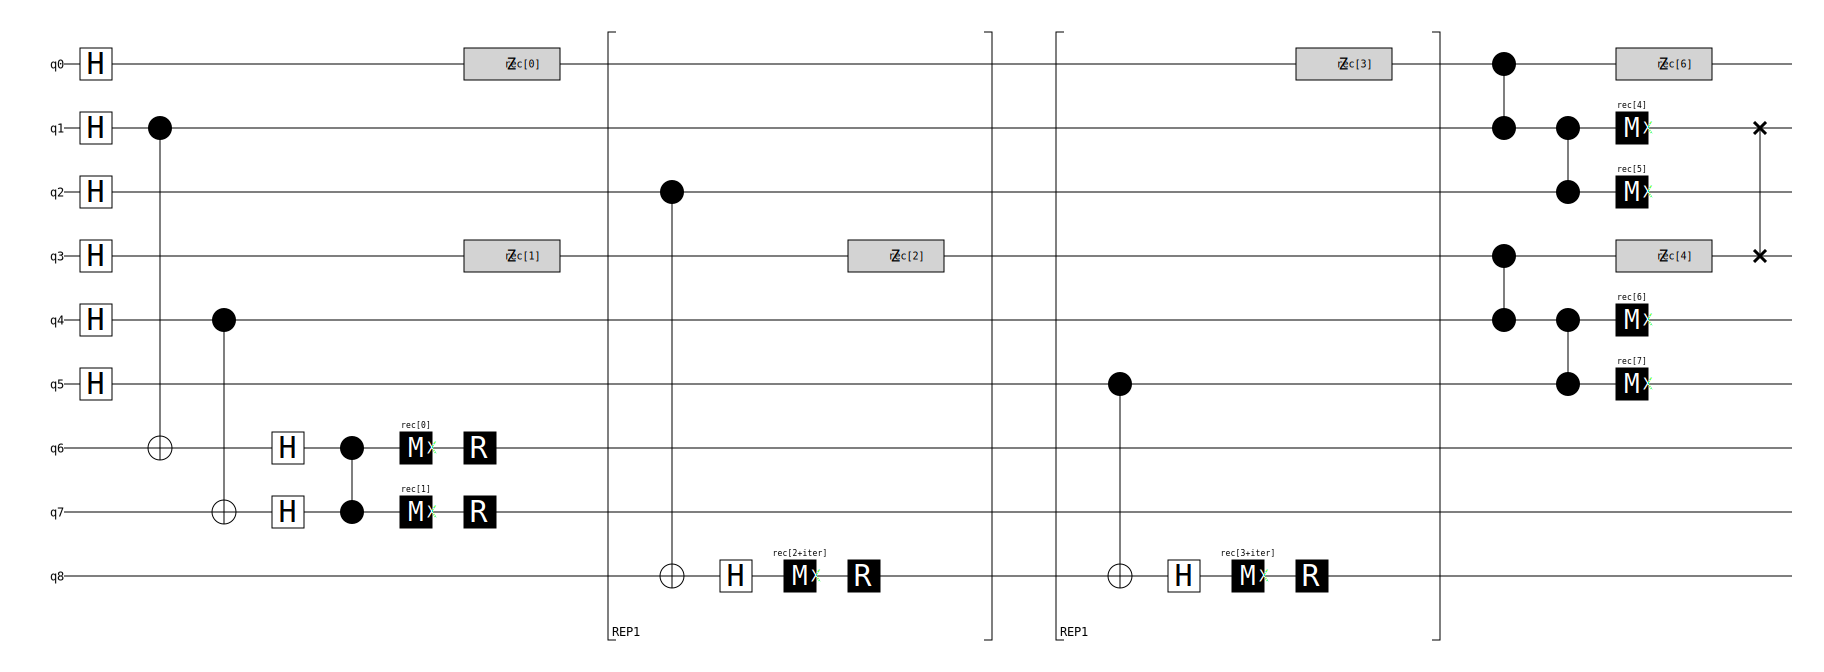

In [62]:
import stim
# anchor  0 3
# outer-e 1 4
# inner-e 2 5
# outer-p 6 7
# photon  8
c = stim.Circuit("""
H 0 1 2 3 4 5
CX 1 6 4 7
H 6 7
CZ 6 7
MX 6 7
R 6 7
CZ rec[-1] 3 rec[-2] 0
REPEAT 1 {
    CX 2 8
    H 8
    MX 8
    R 8
    CZ rec[-1] 3
}
REPEAT 1 {
    CX 5 8
    H 8
    MX 8
    R 8
    CZ rec[-1] 0
}
CZ 0 1 3 4 1 2 4 5
MX 1 2 4 5
CZ rec[-2] 0 rec[-4] 3
SWAP 1 3
""")
t = stim.TableauSimulator()
t.do(c)
t.canonical_stabilizers()
display(c.diagram('timeline-svg'))
for _ in range(1000):
    t = stim.TableauSimulator()
    t.do(c)
    # t.canonical_stabilizers()
    assert t.peek_observable_expectation(stim.PauliString('ZX')) == 1
    assert t.peek_observable_expectation(stim.PauliString('XZ')) == 1

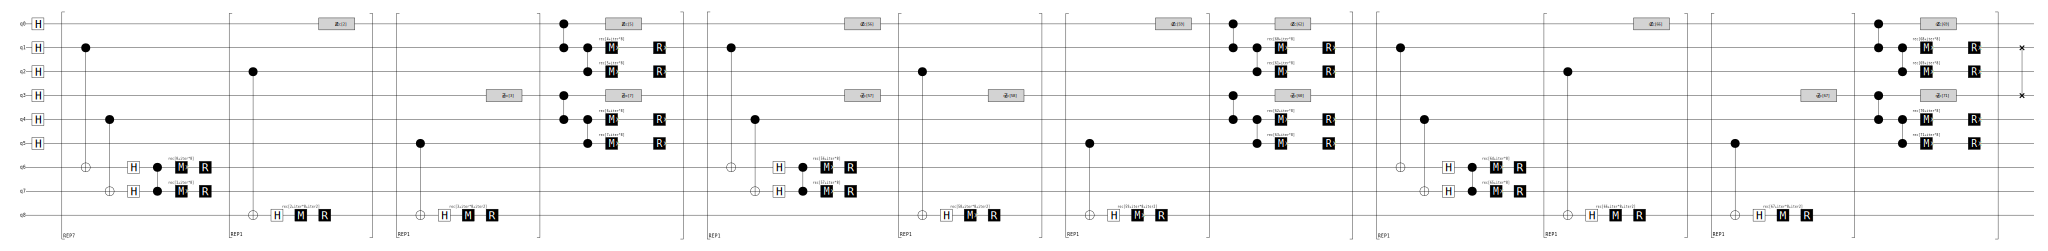

In [77]:
import stim

for i in range(100):

    mz_before = np.random.randint(1, 10)
    mz_after = np.random.randint(1, 10)

    # anchor  0 3
    # outer-e 1 4
    # inner-e 2 5
    # outer-p 6 7
    # photon  8
    c = stim.Circuit(f"""
    H 0 1 2 3 4 5
    # MZ Part
    REPEAT {mz_before} {{
        CX 1 6 4 7
        H 6 7
        CZ 6 7
        MX 6 7
        R 6 7
        REPEAT 1 {{
            CX 2 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 0
        }}
        REPEAT 1 {{
            CX 5 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 3
        }}
        CZ 0 1 3 4 1 2 4 5
        MX 1 2 4 5
        CZ rec[-1] 3 rec[-3] 0
        RX 1 2 4 5
    }}
    # MX Part
    REPEAT {1} {{
        CX 1 6 4 7
        H 6 7
        CZ 6 7
        MX 6 7
        R 6 7
        CZ rec[-1] 3 rec[-2] 0
        REPEAT 1 {{
            CX 2 8
            H 8
            MX 8
            R 8
            CZ rec[-1] 3
        }}
        REPEAT 1 {{
            CX 5 8
            H 8
            MX 8
            R 8
            CZ rec[-1] 0
        }}
        CZ 0 1 3 4 1 2 4 5
        MX 1 2 4 5
        CZ rec[-2] 0 rec[-4] 3
        RX 1 2 4 5
    }}
    # MZ Part
    REPEAT {mz_after} {{
        CX 1 6 4 7
        H 6 7
        CZ 6 7
        MX 6 7
        R 6 7
        REPEAT 1 {{
            CX 2 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 0
        }}
        REPEAT 1 {{
            CX 5 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 3
        }}
        CZ 0 1 3 4 1 2 4 5
        MX 1 2 4 5
        CZ rec[-1] 3 rec[-3] 0
        RX 1 2 4 5
    }}
    SWAP 1 3
    """)
    if i == 0:
        display(c.diagram('timeline-svg'))
    # t = stim.TableauSimulator()
    # t.do(c)
    for _ in range(1000):
        t = stim.TableauSimulator()
        t.do(c)
        t.canonical_stabilizers()
        assert t.peek_observable_expectation(stim.PauliString('ZX')) == 1
        assert t.peek_observable_expectation(stim.PauliString('XZ')) == 1
# t.canonical_stabilizers()

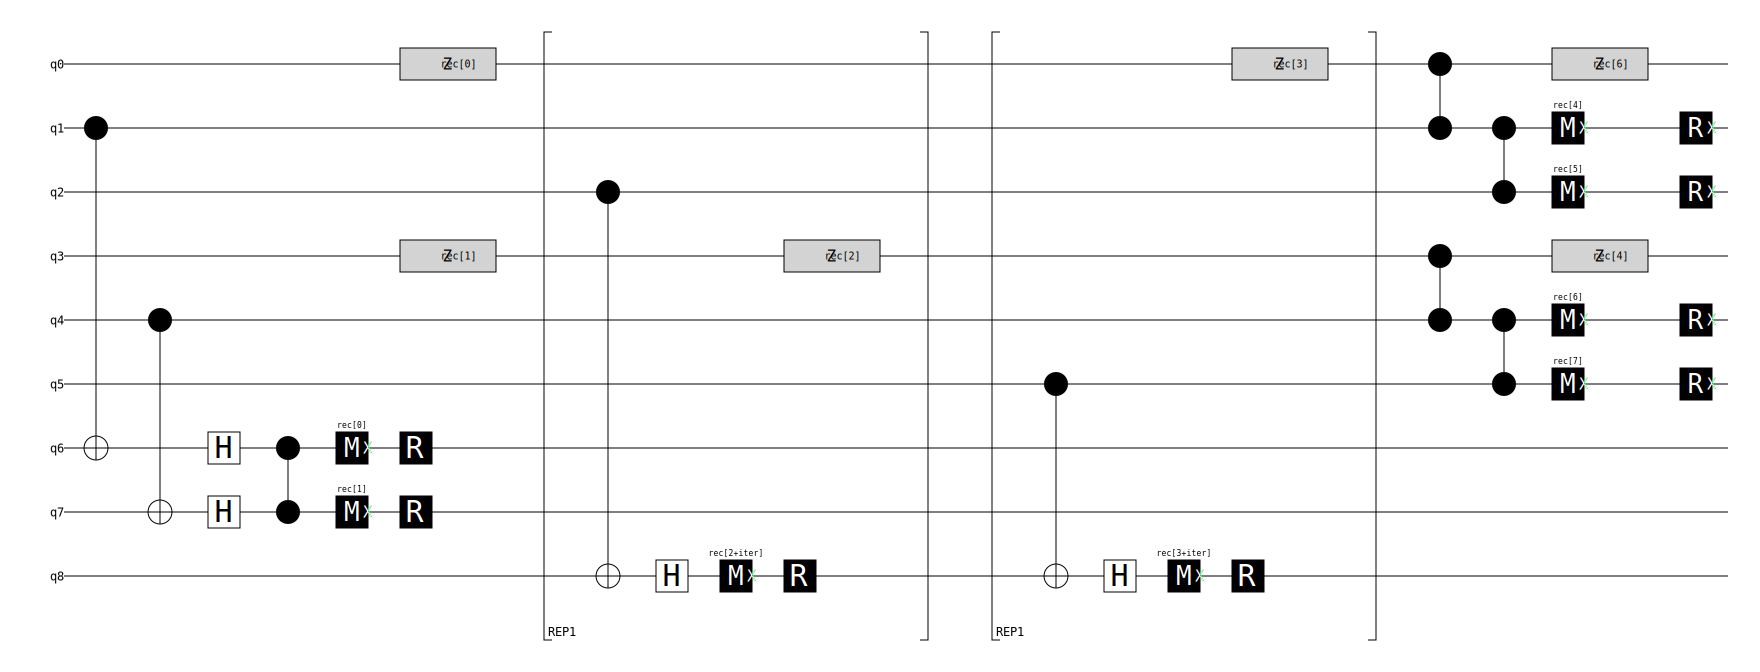

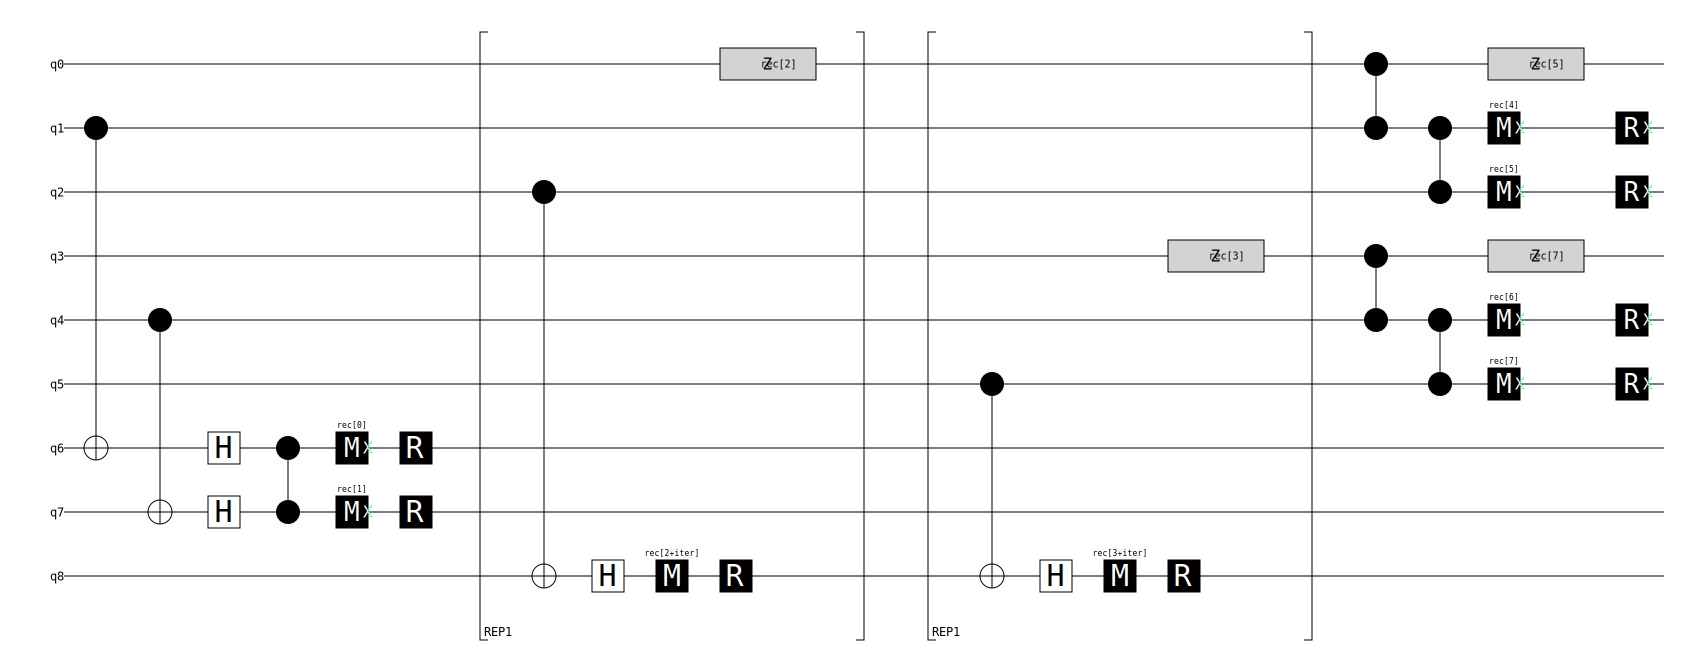

In [94]:
import stim

init_circuit = stim.Circuit(""" 
H 0 1 2 3 4 5
""")
mz_circuit = stim.Circuit(f"""
    CX 1 6 4 7
    H 6 7
    CZ 6 7
    MX 6 7
    R 6 7
    REPEAT 1 {{
        CX 2 8
        H 8
        MZ 8
        R 8
        CZ rec[-1] 0
    }}
    REPEAT 1 {{
        CX 5 8
        H 8
        MZ 8
        R 8
        CZ rec[-1] 3
    }}
    CZ 0 1 3 4 1 2 4 5
    MX 1 2 4 5
    CZ rec[-1] 3 rec[-3] 0
    RX 1 2 4 5
""")
mx_circuit = stim.Circuit("""
    CX 1 6 4 7
    H 6 7
    CZ 6 7
    MX 6 7
    R 6 7
    CZ rec[-1] 3 rec[-2] 0
    REPEAT 1 {
        CX 2 8
        H 8
        MX 8
        R 8
        CZ rec[-1] 3
    }
    REPEAT 1 {
        CX 5 8
        H 8
        MX 8
        R 8
        CZ rec[-1] 0
    }
    CZ 0 1 3 4 1 2 4 5
    MX 1 2 4 5
    CZ rec[-2] 0 rec[-4] 3
    RX 1 2 4 5
""")
display(mx_circuit.diagram('timeline-svg'))
display(mz_circuit.diagram('timeline-svg'))

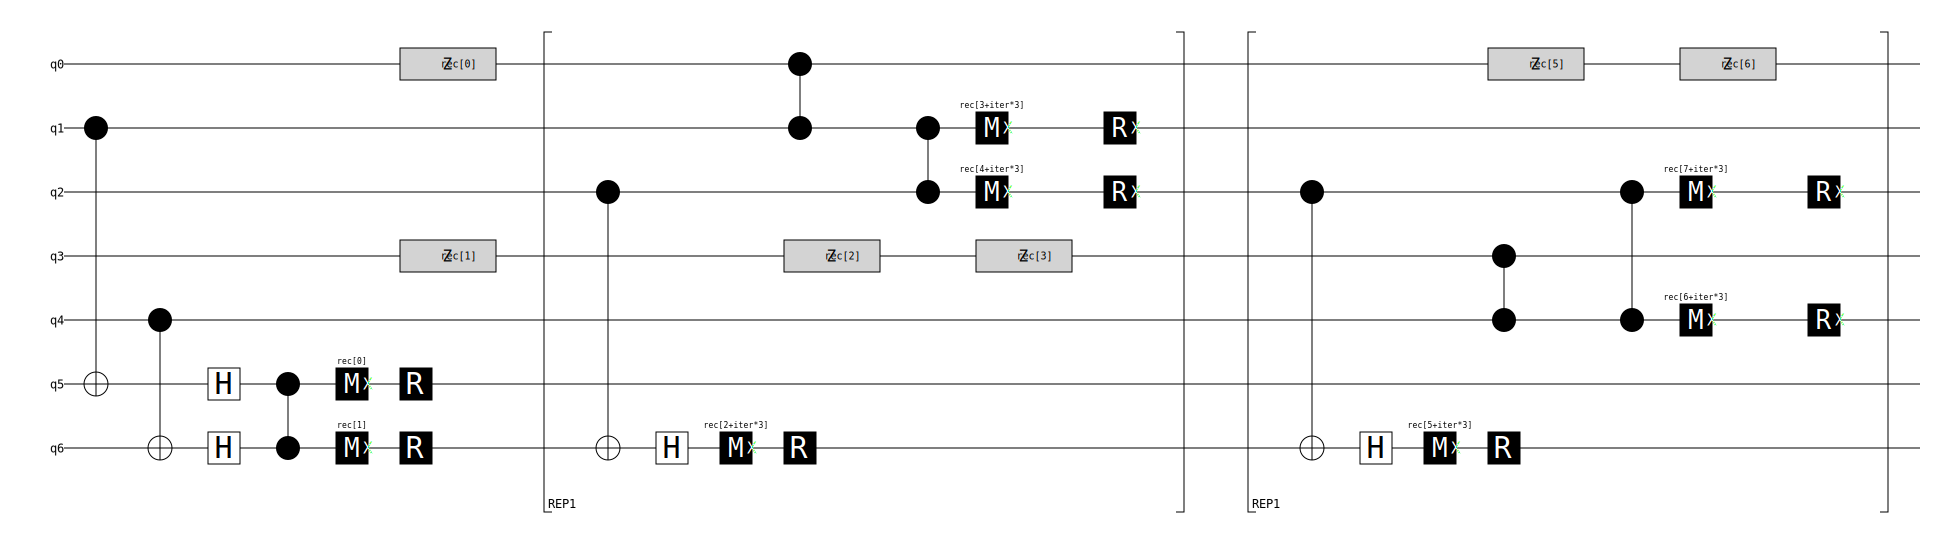

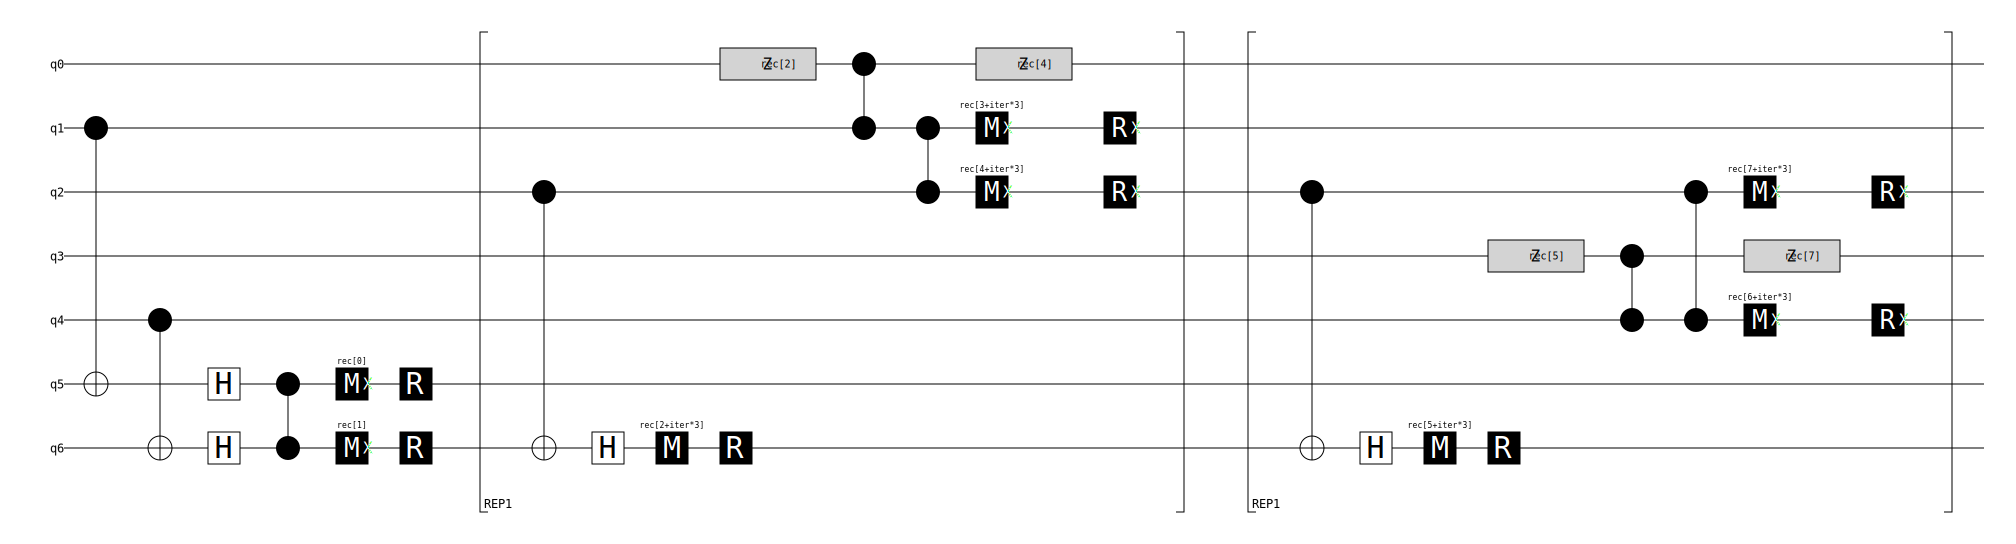

NameError: name 'c' is not defined

In [9]:
import stim
import numpy as np

init_circuit = stim.Circuit(""" 
H 0 1 2 3 4 5
""")
old_mz_circuit = stim.Circuit(f"""
    CX 1 6 4 7
    H 6 7
    CZ 6 7
    MX 6 7
    R 6 7
    REPEAT 1 {{
        CX 2 7
        H 7
        MZ 7
        R 7
        CZ rec[-1] 0
    }}

    REPEAT 1 {{
        CX 5 7
        H 7
        MZ 7
        R 7
        CZ rec[-1] 3
    }}
    CZ 0 1 3 4 1 2 4 5
    MX 1 2 4 5
    CZ rec[-1] 3 rec[-3] 0
    RX 1 2 4 5
""")
mz_circuit = stim.Circuit(f"""
    CX 1 5 4 6
    H 5 6
    CZ 5 6
    MX 5 6
    R 5 6
    REPEAT 1 {{
        CX 2 6
        H 6
        MZ 6
        R 6
        CZ rec[-1] 0
        CZ 0 1 1 2
        MX 1 2
        CZ rec[-1] 0
        RX 1 2
    }}

    REPEAT 1 {{
        CX 2 6
        H 6
        MZ 6
        R 6
        CZ rec[-1] 3
        CZ 3 4 4 2
        MX 4 2
        CZ rec[-1] 3 
        RX 4 2
    }}
""")
mx_circuit = stim.Circuit("""
    CX 1 5 4 6
    H 5 6
    CZ 5 6
    MX 5 6
    R 5 6
    CZ rec[-1] 3 rec[-2] 0
    REPEAT 1 {
        CX 2 6
        H 6
        MX 6
        R 6
        CZ rec[-1] 3
        CZ 0 1 1 2
        MX 1 2
        CZ rec[-2] 3
        RX 1 2
    }
    REPEAT 1 {
        CX 2 6
        H 6
        MX 6
        R 6
        CZ rec[-1] 0
        CZ 3 4 4 2
        MX 4 2
        CZ rec[-2] 0
        RX 2 4
    }
""")
# display(mx_circuit.diagram('timeline-svg'))
display(mx_circuit.diagram('timeline-svg'))
display(mz_circuit.diagram('timeline-svg'))
# display(old_mz_circuit.diagram('timeline-svg'))

for mz_before in range(5):
    for mz_after in range(5):

        circuit = init_circuit
        for _ in range(mz_before):
            circuit += mz_circuit
        circuit += mx_circuit
        for _ in range(mz_after):
            circuit += mz_circuit
        circuit.append("SWAP", [1, 3])

        if mz_before == 1 and mz_after == 1:
            display(circuit.diagram('timeline-svg'))

        t = stim.TableauSimulator()
        for _ in range(1000):
            t.reset(*range(9))
            t.do(c)
            t.canonical_stabilizers()
            assert t.peek_observable_expectation(stim.PauliString('ZX')) == 1
            assert t.peek_observable_expectation(stim.PauliString('XZ')) == 1